Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a ridge regression model with multiple features. Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [2]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [3]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [4]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [5]:
# Looking over my data and displaying ALL columns:
pd.set_option('display.max_columns', None)
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,01/01/2019
1,1,OTHER,21 OFFICE BUILDINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,10018.0,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,0,01/01/2019
2,1,OTHER,21 OFFICE BUILDINGS,4,839,69,NaN,O5,40 WEST 38TH STREET,NaN,10018.0,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,0,01/01/2019
3,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,NaN,R4,"1 SHERIDAN SQUARE, 8C",8C,10014.0,1.0,0.0,1.0,0,500.0,0.0,2,R4,0,01/01/2019
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,NaN,R1,"20 EAST 65TH STREET, B",B,10065.0,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0,01/01/2019


In [6]:
# Narrowing down data to 1 family dwellings that sold between $100K & $2M:
one_fam = df[(df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS') & (df['SALE_PRICE'] > 100000) & (df['SALE_PRICE'] < 2000000)]

In [7]:
# Looking at new df:
one_fam.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,01/01/2019
61,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,NaN,A1,80-23 232ND STREET,NaN,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,01/01/2019
78,2,OTHER,01 ONE FAMILY DWELLINGS,1,4210,19,NaN,A1,1260 RHINELANDER AVE,NaN,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000,01/02/2019
108,3,OTHER,01 ONE FAMILY DWELLINGS,1,5212,69,NaN,A1,469 E 25TH ST,NaN,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,1,A1,125000,01/02/2019
111,3,OTHER,01 ONE FAMILY DWELLINGS,1,7930,121,NaN,A5,5521 WHITTY LANE,NaN,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,1,A5,620000,01/02/2019


In [8]:
# Looking at the shape of the 1 family dwelling subset:
one_fam.shape

(3151, 21)

In [9]:
# Creating train/test split where train is Jan-Mar 19 & test is Apr 19:
train = one_fam[(one_fam['SALE_DATE'] >= '01/01/2019') & (one_fam['SALE_DATE'] <= '03/31/2019')]
test = one_fam[(one_fam['SALE_DATE'] >= '04/01/2019') & (one_fam['SALE_DATE'] <= '04/30/2019')]

In [10]:
# Verify train has correct number of columns:
train.shape

(2507, 21)

In [11]:
# Verifying test has correct number of columns:
test.shape

(644, 21)

In [12]:
# Checking columns:
train.describe(exclude='number')

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,LAND_SQUARE_FEET,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_DATE
count,2507,2507,2507,2507,2507,2507,1,2507,2507,2507
unique,5,7,1,2,13,2497,1,887,11,68
top,4,OTHER,01 ONE FAMILY DWELLINGS,1,A1,57 CHESTNUT STREET,RP.,"4,000",A1,01/31/2019
freq,1204,2360,2507,2476,919,2,1,234,919,78


In [13]:
# Creating target and dropping target, high card columns, NaNs and creating features:
target = 'SALE_PRICE'
high_card =  ['ADDRESS',
              'EASE-MENT',
              'APARTMENT_NUMBER',
              'LAND_SQUARE_FEET',
              'SALE_DATE']
features = train.columns.drop([target] + high_card)
features

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY',
       'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT', 'BUILDING_CLASS_AT_PRESENT',
       'ZIP_CODE', 'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS',
       'GROSS_SQUARE_FEET', 'YEAR_BUILT', 'TAX_CLASS_AT_TIME_OF_SALE',
       'BUILDING_CLASS_AT_TIME_OF_SALE'],
      dtype='object')

In [14]:
# Setting up matrices and vectors:
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [15]:
# Importing category encoders and one hot encoding:
import category_encoders as ce
encoder = ce.one_hot.OneHotEncoder(use_cat_names=True)
X_train_enc = encoder.fit_transform(X_train)
X_test_enc = encoder.transform(X_test)

In [16]:
# Now to look at test:
X_test_enc.head()

,BOROUGH_3,BOROUGH_4,BOROUGH_2,BOROUGH_5,BOROUGH_1,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_EAST NEW YORK,NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_FOREST HILLS,NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_ASTORIA,BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS,TAX_CLASS_AT_PRESENT_1,TAX_CLASS_AT_PRESENT_1D,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT_A9,BUILDING_CLASS_AT_PRESENT_A1,BUILDING_CLASS_AT_PRESENT_A5,BUILDING_CLASS_AT_PRESENT_A0,BUILDING_CLASS_AT_PRESENT_A2,BUILDING_CLASS_AT_PRESENT_A3,BUILDING_CLASS_AT_PRESENT_S1,BUILDING_CLASS_AT_PRESENT_A4,BUILDING_CLASS_AT_PRESENT_A6,BUILDING_CLASS_AT_PRESENT_A8,BUILDING_CLASS_AT_PRESENT_B2,BUILDING_CLASS_AT_PRESENT_S0,BUILDING_CLASS_AT_PRESENT_B3,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE_A9,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A0,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_A3,BUILDING_CLASS_AT_TIME_OF_SALE_S1,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A6,BUILDING_CLASS_AT_TIME_OF_SALE_A8,BUILDING_CLASS_AT_TIME_OF_SALE_S0
18235,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,5913,878,0,1,0,0,0,0,0,0,0,0,0,0,0,10471.0,1.0,0.0,1.0,2272.0,1930.0,1,0,1,0,0,0,0,0,0,0,0,0
18239,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,5488,48,0,0,0,0,1,0,0,0,0,0,0,0,0,10465.0,1.0,0.0,1.0,720.0,1935.0,1,0,0,0,0,1,0,0,0,0,0,0
18244,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,5936,31,0,1,0,0,0,0,0,0,0,0,0,0,0,11209.0,1.0,0.0,1.0,2210.0,1925.0,1,0,1,0,0,0,0,0,0,0,0,0
18280,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,7813,24,0,0,1,0,0,0,0,0,0,0,0,0,0,11210.0,1.0,0.0,1.0,1520.0,1915.0,1,0,0,1,0,0,0,0,0,0,0,0
18285,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,8831,160,1,0,0,0,0,0,0,0,0,0,0,0,0,11229.0,1.0,0.0,1.0,840.0,1925.0,1,1,0,0,0,0,0,0,0,0,0,0


In [17]:
# Entering this code to ignore runtime errors that come up, but don't cause the code to not work:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [18]:
# Doing SelectKBest:
from sklearn.feature_selection import SelectKBest, f_regression
selector = SelectKBest(score_func=f_regression, k=15)
X_train_kbest = selector.fit_transform(X_train_enc, y_train)
X_test_kbest = selector.transform(X_test_enc)

In [19]:
# Looking at the shape of kbest:
X_train_kbest.shape, X_test_kbest.shape

((2507, 15), (644, 15))

In [20]:
# Looking at values in X_train_kbest:
X_train_kbest

array([[1.000e+00, 0.000e+00, 0.000e+00, ..., 1.325e+03, 0.000e+00,
        0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 2.001e+03, 0.000e+00,
        0.000e+00],
       [0.000e+00, 1.000e+00, 0.000e+00, ..., 2.043e+03, 0.000e+00,
        0.000e+00],
       ...,
       [0.000e+00, 0.000e+00, 1.000e+00, ..., 1.807e+03, 0.000e+00,
        0.000e+00],
       [0.000e+00, 0.000e+00, 1.000e+00, ..., 6.210e+02, 0.000e+00,
        0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.163e+03, 0.000e+00,
        0.000e+00]])

In [21]:
# Which features were selected:
mask = selector.get_support()
mask

array([ True, False,  True,  True, False,  True,  True, False, False,
        True, False, False, False, False, False,  True, False, False,
       False,  True, False, False,  True, False, False, False, False,
       False, False, False,  True, False,  True,  True,  True, False,
       False, False, False,  True, False, False,  True, False, False,
       False, False, False])

In [22]:
# Look at the column names that were selected:
X_train_enc.columns[mask]

Index(['BOROUGH_3', 'BOROUGH_2', 'BOROUGH_5', 'NEIGHBORHOOD_OTHER',
       'NEIGHBORHOOD_FLUSHING-NORTH', 'NEIGHBORHOOD_FOREST HILLS', 'BLOCK',
       'BUILDING_CLASS_AT_PRESENT_A5', 'BUILDING_CLASS_AT_PRESENT_A3',
       'ZIP_CODE', 'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'GROSS_SQUARE_FEET',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A5',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A3'],
      dtype='object')

In [23]:
# How many features should we select?
# This works, but has many runtime issues in between, so I removed the outputs.
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

mae_list = []
for k in range(1, X_train_enc.shape[1]+1):
  print(f'{k} features')
  selector = SelectKBest(score_func=f_regression, k=k)
  X_train_kbest = selector.fit_transform(X_train_enc, y_train)
  X_test_kbest = selector.transform(X_test_enc)
  model = LinearRegression()
  model.fit(X_train_kbest, y_train)
  y_pred = model.predict(X_test_kbest)
  mae = mean_absolute_error(y_pred, y_test)
  print(f'MAE on test set: ${mae:.2f}')
  mae_list.append(mae)

1 features
MAE on test set: $183640.59
2 features
MAE on test set: $182569.26
3 features
MAE on test set: $182569.26
4 features
MAE on test set: $183440.75
5 features
MAE on test set: $181935.13
6 features
MAE on test set: $176456.32
7 features
MAE on test set: $177001.36
8 features
MAE on test set: $176707.36
9 features
MAE on test set: $171663.46
10 features
MAE on test set: $170976.54
11 features
MAE on test set: $170506.83
12 features
MAE on test set: $162300.68
13 features
MAE on test set: $163558.86
14 features
MAE on test set: $162562.33
15 features
MAE on test set: $162563.55
16 features
MAE on test set: $162419.48
17 features
MAE on test set: $162419.48
18 features
MAE on test set: $162177.33
19 features
MAE on test set: $162177.33
20 features
MAE on test set: $157892.53
21 features
MAE on test set: $157965.58
22 features
MAE on test set: $157965.58
23 features
MAE on test set: $157965.58
24 features
MAE on test set: $157526.96
25 features
MAE on test set: $157427.92
26 featur

In [24]:
# Importing RidgeCV, Ridge, matplotlib:
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

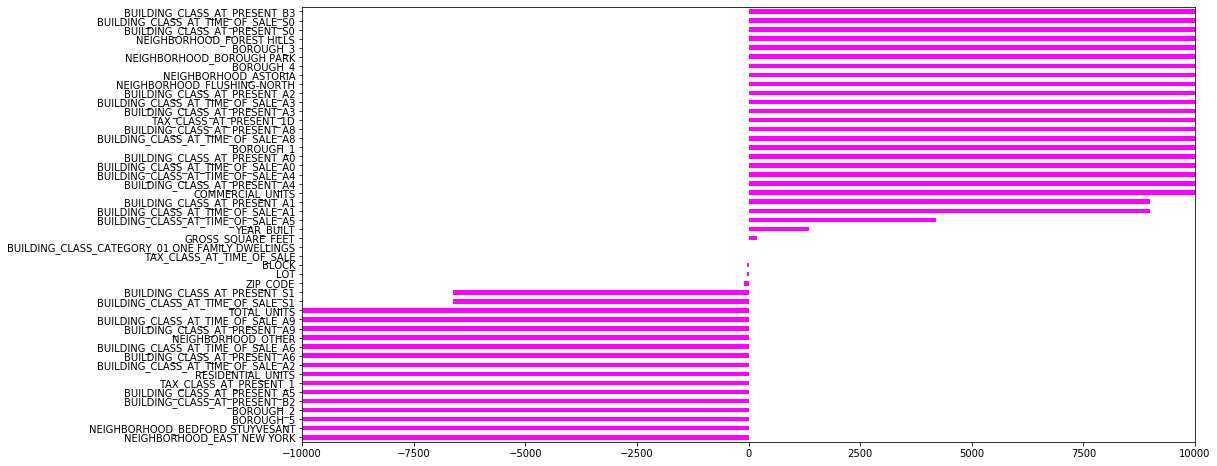

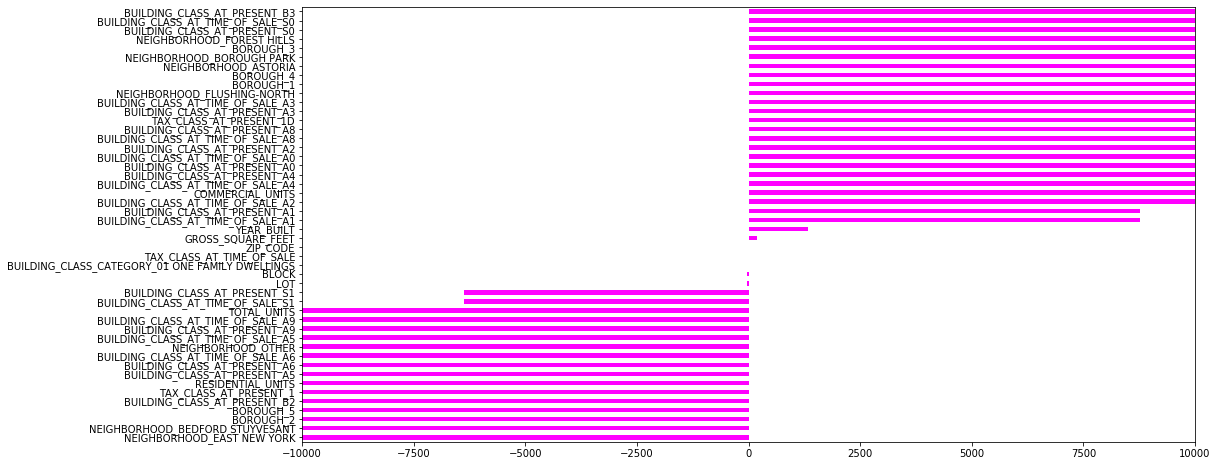

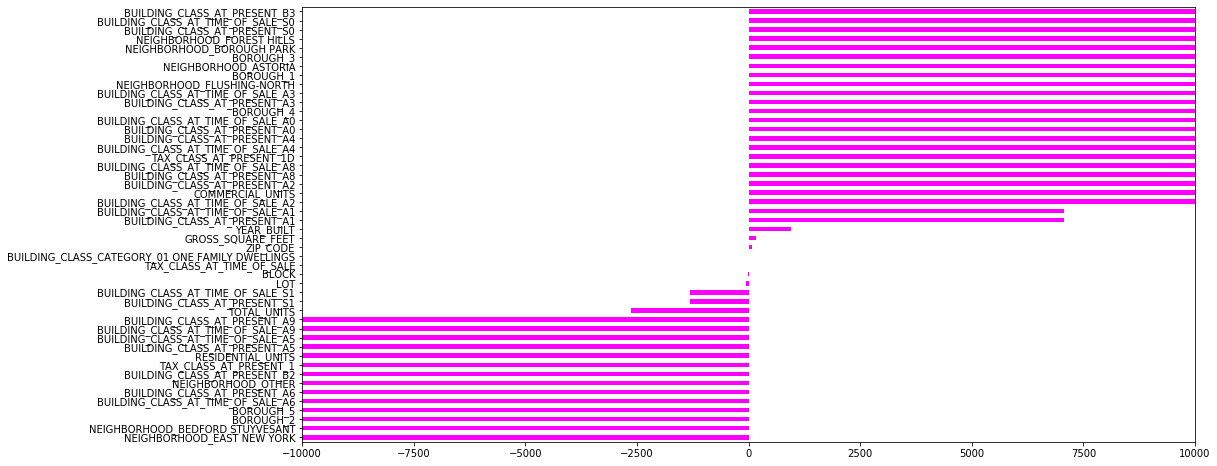

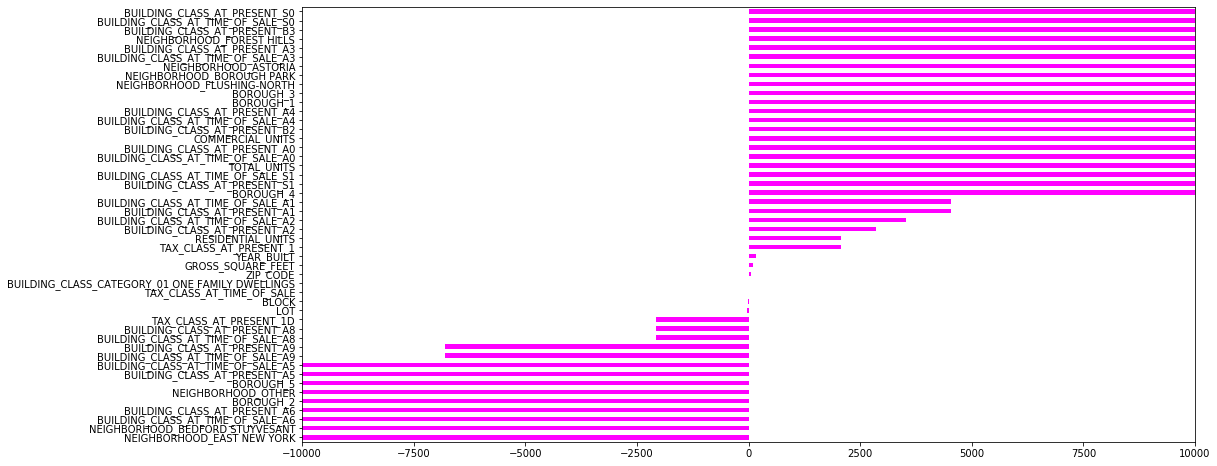

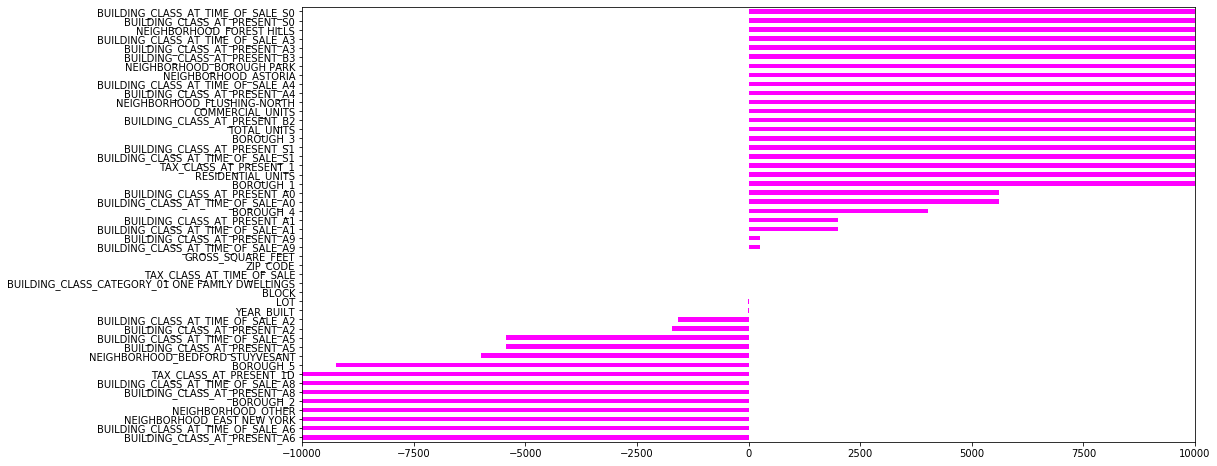

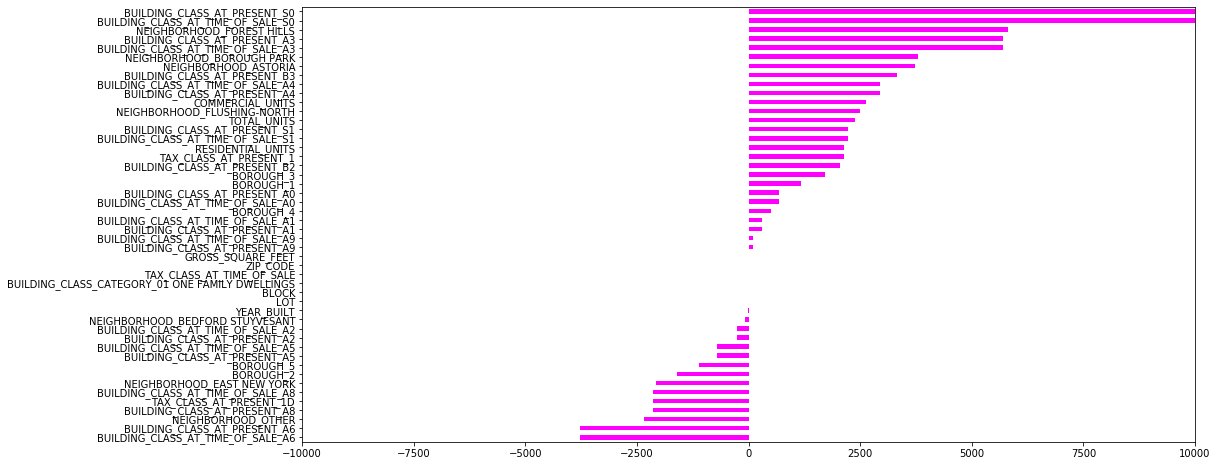

In [25]:
# Ridge regression:
%matplotlib inline

from IPython.display import display, HTML

for alpha in [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]:
    
    # Fitting the Ridge Regression model:
    display(HTML(f'Ridge Regression, with alpha={alpha}'))
    model = Ridge(alpha=alpha, normalize=True)
    model.fit(X_train_enc, y_train)
    y_pred = model.predict(X_test_enc)
    
    # Now getting the Test MAE:
    mae = mean_absolute_error(y_test, y_pred)
    display(HTML(f'Test Mean Absolute Error: ${mae:,.0f}'))
    
    # Finally, plot the coefficients:
    coefficients = pd.Series(model.coef_, X_train_enc.columns)
    plt.figure(figsize=(16,8))
    coefficients.sort_values().plot.barh(color='magenta')
    plt.xlim(-10000,10000)
    plt.show()